In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, seed_everything
from torchvision import transforms
from torchvision.datasets import MNIST
os.chdir("/nfs/homedirs/schwienb/project-4")

In [5]:
from src.data.mnist import MNISTDataModule, ConstantDataset, RandomDataset
from src.data.bgaugmnist import BgAugMNISTDataModule,BgAugFashionMNISTDataModule
from src.data.fashionmnist import FashionMNISTDataModule
from src.models.bg_aug_pixelcnn import BgAugPixelCNN
from src.models.pixelcnn import PixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
import torch.nn.functional as F

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(42)


42

In [7]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=3,
   verbose=True,
)

EarlyStopping mode set to min for monitoring val_loss.


In [8]:
fashionmnist_exp = Experiment(BgAugPixelCNN, BgAugFashionMNISTDataModule, "BgAugPixelCNN_1_DL_FashionMNIST_1", callbacks=[early_stop_callback])

Extracting ./data/FashionMNISTBgAug/raw/train-images-idx3-ubyte.gz to ./data/FashionMNISTBgAug/raw


Extracting ./data/FashionMNISTBgAug/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNISTBgAug/raw


Extracting ./data/FashionMNISTBgAug/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNISTBgAug/raw


Extracting ./data/FashionMNISTBgAug/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNISTBgAug/raw
Processing...


/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done!




In [11]:
fashionmnist_exp.trainer.fit(fashionmnist_exp.model, fashionmnist_exp.dataset)

/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: Found unsupported keys in the lr scheduler dict: ['name']
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

  | Name   | Type       | Params
--------------------------------------
0 | blocks | Sequential | 1 M   


/nfs/students/winter-term-2020/project-4/schwienb/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


1

In [12]:
fashionmnist_exp.save()

/nfs/homedirs/schwienb/project-4/src/utils/pixelcnn.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out[:, :, i, j]).data


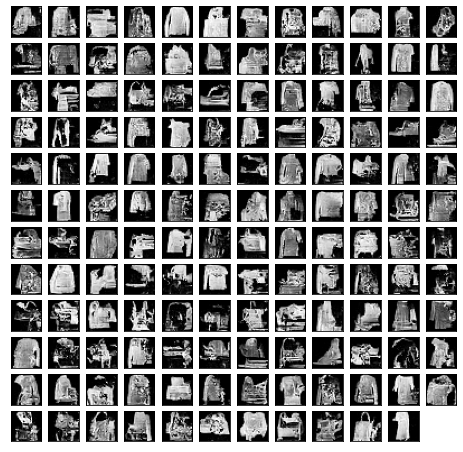

In [13]:
generate_images(fashionmnist_exp.model)

In [61]:
mnist_exp_old = Experiment(PixelCNN, MNISTDataModule, "PixelCNN_MNIST_1.3", callbacks=[early_stop_callback])
mnist_exp_old.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [8]:
mnist_exp = Experiment(BgAugPixelCNN, BgAugMNISTDataModule, "BgAugPixelCNN_MNIST_1", callbacks=[early_stop_callback])
mnist_exp.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [14]:
data = mnist_exp.dataset.test_dataloader()

In [17]:
img = next(iter(data))
res = mnist_exp.model(img[0].cuda())

In [18]:
res.shape

torch.Size([1, 256, 28, 28])

In [33]:
img[0][0][0][7,6] * 255

tensor(84.)

In [41]:
mnist_exp.model.eval()
res = mnist_exp.model(img[0].cuda())

In [11]:
def likelihood(img_data, model):
    img = img_data[0]
    img = img.cuda()
    model.eval()
    res = model(img)
    like = torch.zeros((28,28))
    for i in range(28):
        for j in range(28):
            probs = F.softmax(res[0, :, 1, 1], dim=0)
            prob = (img[0, :, i, j] * 255.).int().cpu().numpy()[0]
            like[i][j] = probs[prob]
    return like

In [12]:
def draw_likelihood_plot(data, model):
    columns = 3
    rows = 3
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    i = 1
    for img in iter(data):
        if i <= 9:
            fig.add_subplot(rows, columns, i)
            like = likelihood(img, model)
            plt.imshow(like.detach().cpu().numpy(), cmap='gray')
            plt.xticks([])
            plt.yticks([])
        i += 1
    plt.show()

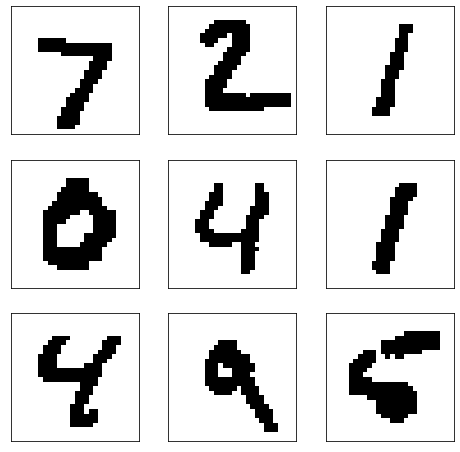

In [15]:
draw_likelihood_plot(data, mnist_exp.model)

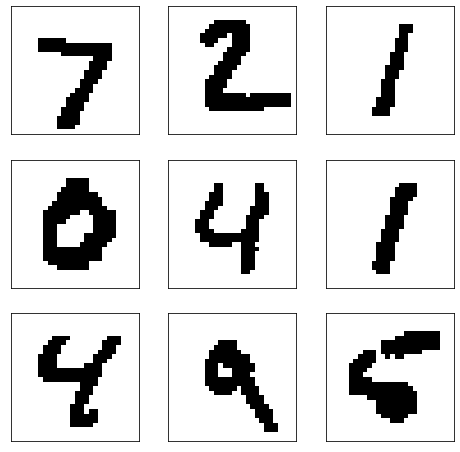

In [69]:
draw_likelihood_plot(data, mnist_exp_old.model)

In [14]:
mnist_exp = Experiment(BgAugPixelCNN, BgAugMNISTDataModule, "BgAugPixelCNN_1_DL_MNIST_1", callbacks=[early_stop_callback])
mnist_exp.load()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [27]:
mnist_testdataloader = mnist_exp.dataset.test_dataloader()
fashionmnist_testdataloader = fashionmnist_exp.dataset.test_dataloader()

In [28]:
mnist_test_fashion = fashionmnist_exp.trainer.test(fashionmnist_exp.model, test_dataloaders=[fashionmnist_testdataloader], verbose=False)

Set SLURM handle signals.


In [29]:
mnist_test_mnist = fashionmnist_exp.trainer.test(fashionmnist_exp.model, test_dataloaders=[mnist_testdataloader], verbose=False)

Set SLURM handle signals.


In [30]:
losses = torch.Tensor(mnist_test_mnist[1]['loss']).numpy()
fashionlosses = torch.Tensor(mnist_test_fashion[1]['loss']).numpy()

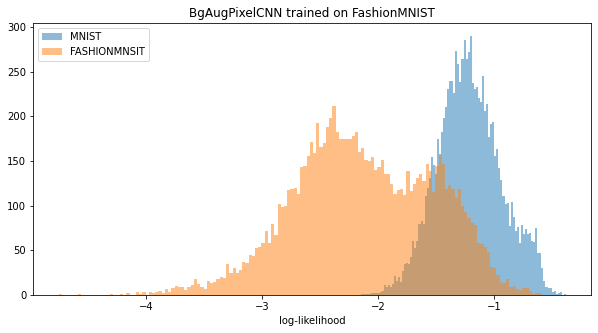

In [32]:
plt.figure(figsize=(10,5))
plt.hist(losses * -1, 100, alpha=0.5, label='MNIST')
plt.hist(fashionlosses * -1, 150, alpha=0.5, label='FASHIONMNSIT')
plt.legend(loc='upper left')
plt.xlabel('log-likelihood')
plt.title('BgAugPixelCNN trained on FashionMNIST')
plt.show()